## H2: Particle filter for a linear Gaussian state-space model

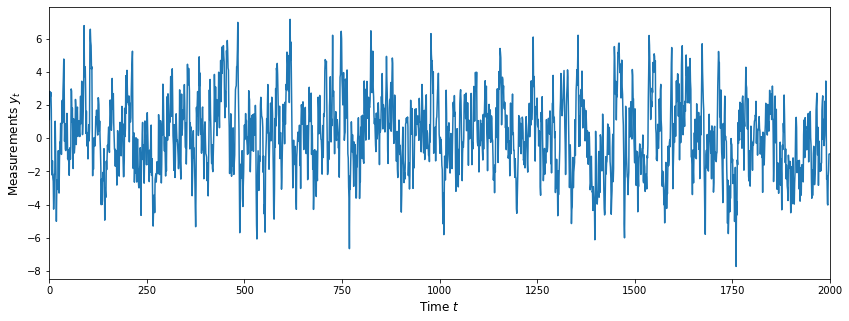

In [39]:
import os
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def generate_data(T, A=0.8, C=2, Q=0.5, R=0.1):
    y = np.zeros(T)
    x = np.zeros(T+1)
    x[0] = np.random.normal(loc=0.0, scale=np.sqrt(2.0) )
    for t in range(T):
        x[t+1] = np.random.normal(loc=A*x[t], scale=np.sqrt(Q))
        y[t] = np.random.normal(loc=C*x[t+1], scale=np.sqrt(R))
    return y, x

np.random.seed(42)
T=2000
y, x = generate_data(T)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(y)
ax.set_xlabel("Time $t$", fontsize=12); ax.set_ylabel("Measurements $y_t$", fontsize=12)
ax.set_xlim(-1, 2001)
plt.show()
fig.savefig('h2_measurements.png')

## (b) Kalman filter

In [40]:
# The Kalman filter
def kalman_filter(y, A, C, Q, R, P0):
    T = len(y)
    # Define filtering means x_hat and covariances P_hat
    x_hat = np.zeros(T+1)
    P_hat = np.zeros(T+1)
    # Initialize mean and cov at time 0 as zero and P0 respectively
    P_hat[0] = P0
    for t in range(1, T+1):
        P_time_update = A**2 * P_hat[t-1] + Q
        K = P_time_update * C / (P_time_update * C**2 + R)
        
        x_hat[t] = A*x_hat[t-1] + K*(y[t-1] - C*A*x_hat[t-1])
        P_hat[t] = P_time_update - K*C*P_time_update
    return x_hat, P_hat

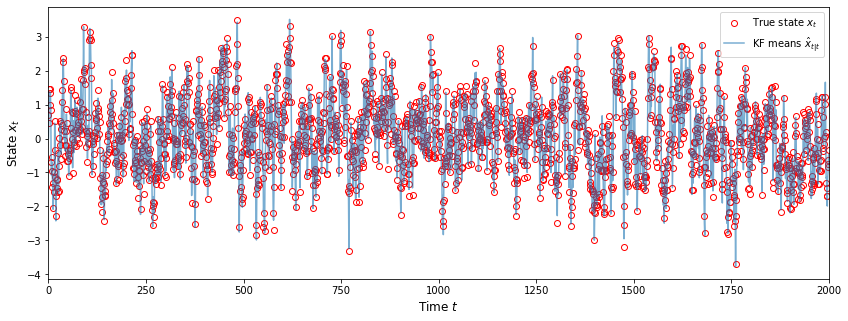

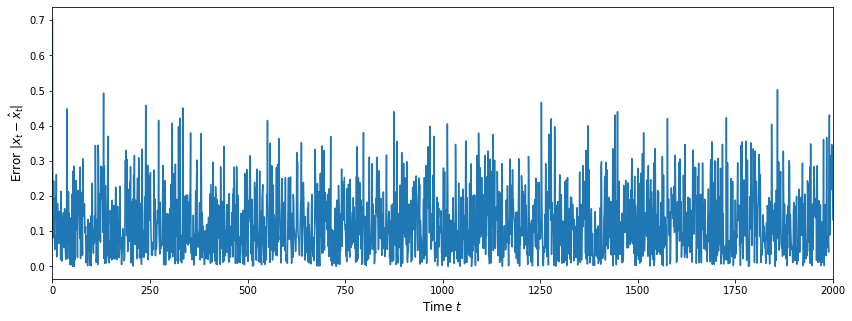

In [41]:
means_kf, cov_kf = kalman_filter(y, A=0.8, C=2.0, Q=0.5, R=0.1, P0=2.0)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(x, 'ro', label='True state $x_t$', fillstyle='none')
ax.plot(means_kf, '-', label='KF means $\hat{x}_{t|t}$', fillstyle='none', alpha=0.6)
ax.set_xlabel("Time $t$", fontsize=12); ax.set_ylabel("State $x_t$", fontsize=12)
ax.legend()
ax.set_xlim(-1, 2001)
plt.show()
fig.savefig("kf_means1.png")

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(abs(x - means_kf), '-',  fillstyle='none')
ax.set_xlabel("Time $t$", fontsize=12); ax.set_ylabel("Error $|x_t - \hat{x}_t|$", fontsize=12)
ax.set_xlim(-1, 2001)
plt.show()
fig.savefig("abs_error_kf_means.png")

## (c) Bootstrap PF

In [47]:
# Bootstrap particle filter
def bootstrap_particle_filter(y, N, theta, resampling_type='multinomial'):

    # Static parameters 
    A = theta[0] # for mean of transition model
    C = theta[1] # for mean of observations
    Q = theta[2] # variance of process noise
    R = theta[3] # variance of observations
    
    # Initialization
    T = len(y)
    x = np.zeros([T+1, N])
    w = np.zeros([T+1, N])
    ancs = np.zeros([T+1, N], dtype=int)
    
    x[0, :] = np.random.normal(0.0, 1.0, size=N)
    w[0, :] = np.ones(N) / N
    ancs[0, :] = range(N)
    
    for t in range(1, T+1):
        
        if resampling_type == 'multinomial':
            ancs[t, :] = multinomial_resampling(w[t-1, :])
        else:
            ancs[t, :] = np.choice(N, N, p=w[t-1, :])
        
        x[t, :] = np.random.normal(loc=A*x[t-1, ancs[t, :]], scale=np.sqrt(Q) )
        w_tilde = norm.logpdf(y[t-1], loc=C*x[t, :], scale=np.sqrt(R) )
                                  
        # Normalize with log trick
        max_w_tilde = np.max(w_tilde)
        w_tilde = w_tilde - max_w_tilde
        #w_bar = np.exp(log_w_tilde - np.max(log_w_tilde))
        w[t, :] = np.exp(w_tilde) / np.sum(np.exp(w_tilde))
    return x, w, ancs

def multinomial_resampling(w):
    N = len(w)
    # Generate ordered uniform random numbers 
    u_sample = np.random.uniform(size=N)
    u = np.zeros(N)
    u[N-1] = u_sample[N-1]**(1/N)
    for k in range(N-1, 0, -1):
        u[k-1] = u[k] * u_sample[k-1]**(1/k) 
    
    # Generate offsprings
    ancestors = np.zeros(N, dtype=int)
    i = 0
    j = 0
    w_sum = 0.0
    while j < N:
        w_sum += w[i]
        while j < N and w_sum > u[j]:
            ancestors[j] = i
            j += 1
        i += 1 
    return ancestors

In [62]:
# Parameters 
A=0.8; C=2.0; Q=0.5; R=0.1; P0=2.0
# Run Kalman filter
T = len(y)
means_kf, cov_kf = kalman_filter(y, A, C, Q, R, P0)

# Run bootstrap particle filter
# Compute BPF mean and variance
# See Eq. 13 in http://user.it.uu.se/~thosc112/pubpdf/schongk2011.pdf
theta = [A, C, Q, R]
n_samples = [10, 50, 100, 2000, 5000]
means_bpf = np.zeros([len(n_samples), T+1])
cov_bpf = np.zeros([len(n_samples), T+1])
for i, n in enumerate(n_samples):
    x_bpf, w_bpf, _ = bootstrap_particle_filter(y, n, theta, resampling_type='multinomial')
    means_bpf[i, :] = np.sum(x_bpf * w_bpf, axis=-1)
    cov_bpf[i, :] = np.sum( (x_bpf - means_bpf[i,:][:,None])**2 * w_bpf, axis=-1) #np.sum( (x_bpf - means_bpf[:,None])**2 * w_bpf, axis=-1)

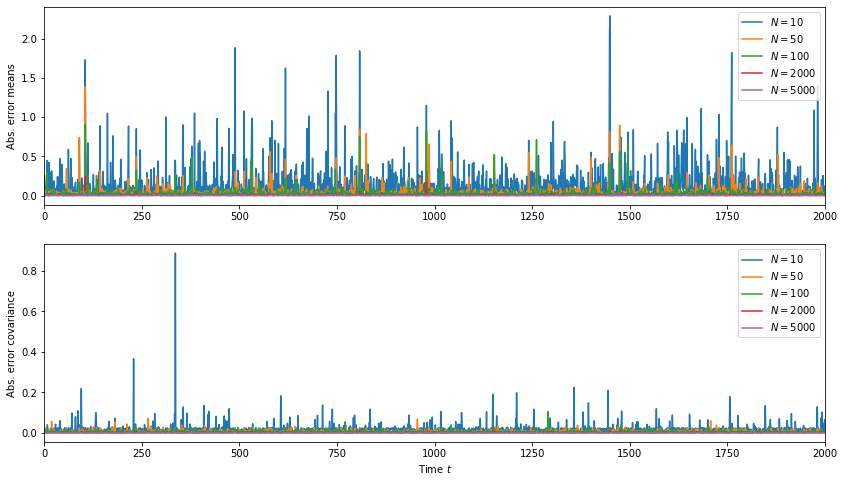

N = 10 Mean error: 0.1404 Covariance error: 0.0179
N = 50 Mean error: 0.0415 Covariance error: 0.0064
N = 100 Mean error: 0.0267 Covariance error: 0.0045
N = 2000 Mean error: 0.0051 Covariance error: 0.0010
N = 5000 Mean error: 0.0032 Covariance error: 0.0006


In [70]:
fig, ax = plt.subplots(nrows=2, figsize=(14, 8))
avg_absdiff = np.zeros([len(n_samples), 2])
array = np.linspace(1, T, T, dtype=int)
for i, n in enumerate(n_samples):
    err_means = abs(means_kf[1:] - means_bpf[i, 1:])
    ax[0].plot(array, err_means, label="$N = {:d}$".format(n))
    
    err_cov = abs(cov_kf[1:] - cov_bpf[i, 1:])
    ax[1].plot(array, err_cov, label="$N = {:d}$".format(n))
    
    avg_absdiff[i, 0] = np.mean(err_means)
    avg_absdiff[i, 1] = np.mean(err_cov)

ax[0].set_xlim(0, T+1); ax[0].set_ylabel("Abs. error means")
ax[0].legend(loc="upper right")
ax[1].set_xlim(0, T+1); ax[1].set_xlabel("Time $t$"); ax[1].set_ylabel("Abs. error covariance")
ax[1].legend(loc="upper right")
plt.show()
fig.savefig("abs_errors_bpf.png")
#adiff = np.mean(np.abs(means_kf - means_bpf))
#print("Average absolute difference: ", adiff)
for i, n in enumerate(n_samples):
    print("N = {:d} Mean error: {:.4f} Covariance error: {:.4f}".format(n, avg_absdiff[i, 0], avg_absdiff[i, 1]))

## (d) Fully-adapted PF

In [65]:
def fully_adapted_particle_filter(y, n_particles, theta):
    # Static parameters
    A = theta[0] # for mean of transition model
    C = theta[1] # for mean of observations
    Q = theta[2] # variance of process noise
    R = theta[3] # variance of observations
    
    # Initialization
    T = len(y)
    ancestors = np.zeros([T+1, n_particles], dtype=int)
    ancestors[0, :] = range(n_particles)
    x = np.zeros([T+1, n_particles])
    x[0, :] = np.random.normal(0.0, 1.0, size=n_particles)
    w = np.zeros([T+1, n_particles])
    w[0, :] = np.ones(n_particles) / n_particles
    
    for t in range(1, T+1):
        
        # Compute adjustment multipliers using p(y_t | x_{t-1})
        v = norm.pdf(y[t-1], loc=A*C*x[t-1, :], scale=np.sqrt(C**2 * Q + R))
        
        # Resample x with probabilities proportional to w_{t-1}*v_{t-1} 
        resampling_weights = (w[t-1, :] * v) / np.sum(w[t-1, :] * v)
        ancs = np.random.choice(n_particles, n_particles, p=resampling_weights)
        x_resampled = x[t-1, ancs]
        
        # Sample x from posterior p(x_t | x_{t-1}, y_t)
        x[t, :] = np.random.normal(loc=(C*y[t-1] + A*(R/Q)*x_resampled)/(C**2 + (R/Q)),
                            scale=np.sqrt( R/(C**2 + (R/Q)) ) )
        
        # Don't need to update weights, since they are w_tilde is const. -> w = 1/n_particles
        # w = omega(x_resampled, x, y) = p(y | x_resampled) / v(x_resampled, y) = 1
        w[t, :] = w[t-1, :]
        ancestors[t, :] = ancs
    return x, w, ancestors

def systematic_resampling(w):
    N = len(w)
    # Draw random numbers uniformly from equidistant intervals
    u = np.zeros(N)
    u[0] = np.random.uniform(0.0, 1/N)
    for i in range(1,N):
        u[i] = u[i-1] + 1/N
    #print(u)
    ancestors = np.zeros(N, dtype=int)
    i = 0
    j = 0
    w_sum = 0.0
    while j < N:
        w_sum += w[i]
        while j < N and w_sum > u[j]:
            ancestors[j] = i
            j += 1
        i += 1 
    return ancestors

In [67]:
# Parameters 
A=0.8; C=2.0; Q=0.5; R=0.1; P0=2.0
# Run Kalman filter
T = len(y)

# Run bootstrap particle filter
# Compute BPF mean and variance
# See Eq. 13 in http://user.it.uu.se/~thosc112/pubpdf/schongk2011.pdf
theta = [A, C, Q, R]
n_samples = [10, 50, 100, 2000, 5000]
means_fapf = np.zeros([len(n_samples), T+1])
cov_fapf = np.zeros([len(n_samples), T+1])
for i, n in enumerate(n_samples):
    x_fapf, w_fapf, _ = fully_adapted_particle_filter(y, n, theta)
    means_fapf[i, :] = np.sum(x_fapf * w_fapf, axis=-1)
    cov_fapf[i, :] = np.sum( (x_fapf - means_fapf[i,:][:,None])**2 * w_fapf, axis=-1) 

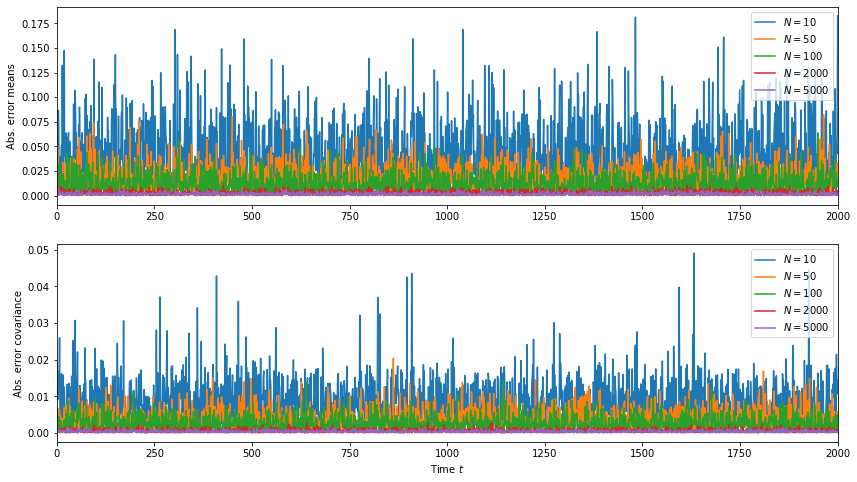

N = 10 Mean error: 0.0401 Covariance error: 0.0082
N = 50 Mean error: 0.0175 Covariance error: 0.0037
N = 100 Mean error: 0.0125 Covariance error: 0.0027
N = 2000 Mean error: 0.0027 Covariance error: 0.0006
N = 5000 Mean error: 0.0017 Covariance error: 0.0004


In [69]:
fig, ax = plt.subplots(nrows=2, figsize=(14, 8))
avg_absdiff = np.zeros([len(n_samples), 2])
array = np.linspace(1, T, T, dtype=int)
for i, n in enumerate(n_samples):
    err_means = abs(means_kf[1:] - means_fapf[i, 1:])
    ax[0].plot(array, err_means, label="$N = {:d}$".format(n))
    
    err_cov = abs(cov_kf[1:] - cov_fapf[i, 1:])
    ax[1].plot(array, err_cov, label="$N = {:d}$".format(n))
    
    avg_absdiff[i, 0] = np.mean(err_means)
    avg_absdiff[i, 1] = np.mean(err_cov)

ax[0].set_xlim(0, T+1); ax[0].set_ylabel("Abs. error means")
ax[0].legend(loc="upper right")
ax[1].set_xlim(0, T+1); ax[1].set_xlabel("Time $t$"); ax[1].set_ylabel("Abs. error covariance")
ax[1].legend(loc="upper right")
plt.show()
fig.savefig("abs_errors_fapf.png")
#adiff = np.mean(np.abs(means_kf - means_bpf))
#print("Average absolute difference: ", adiff)
for i, n in enumerate(n_samples):
    print("N = {:d} Mean error: {:.4f} Covariance error: {:.4f}".format(n, avg_absdiff[i, 0], avg_absdiff[i, 1]))

## (e) Plot trajectories for FAPF

In [112]:
def plot_trajectories(x, ancestors, figname=None):
    N = x.shape[0] # number pf particles
    T = x.shape[1] - 1 # number of time steps in dataset
    
    # Get trajectories of dead particles
    dead_particles = [] # Store state/particle values 

    for t in range(1, T + 1):
        dead_ind = np.setdiff1d(range(N), ancestors[:, t]) #returns unique values in first arg that are not in arg2
        traj_of_dead_ind = np.zeros((len(dead_ind), t))
        ancestors_of_dead_ind = dead_ind
        for s in range(t, 0, -1):
            #print("s: ", s)
            ancestors_of_dead_ind = ancestors[ancestors_of_dead_ind, s - 1]
            traj_of_dead_ind[:, s - 1] = x[ancestors_of_dead_ind, s - 1]

        dead_particles.append(traj_of_dead_ind)
    
    # Get trajectories of particles that survived
    alive_particles = np.zeros((N, T + 1))
    alive_particles[:, T] = x[:, T]
    ancs_t = range(N)
    for t in range(T, 0, -1):
        ancs_t = ancestors[ancs_t, t - 1]
        alive_particles[:, t - 1] = x[ancs_t, t - 1]
        
    # plot dead and alive particles
    fig, ax = plt.subplots(figsize=(16, 5))
    
    for traj in dead_particles:
        for i in range(traj.shape[0]):
            ax.plot(traj[i, :], 'o-', linestyle='-', fillstyle='none', 
                    color='grey', markersize=3, lw=1,
                    alpha=0.5, antialiased=True);
    
    for i in range(N):
        ax.plot(alive_particles[i, :], 'o-', linestyle='-', markeredgecolor='r',
                    markerfacecolor='r',
                    color='k', markersize=4, lw=1,
                    alpha=1, antialiased=True);
    

    ax.set_xlabel('Time $t$'); ax.set_ylabel('State $X$')
    ax.set_xlim(-1, T+1)
    plt.show()    
    if figname is not None:
        fig.savefig(figname + '.png')

In [115]:
def systematic_resampling(w):
    N = len(w)
    # Draw random numbers uniformly from equidistant intervals
    u = np.zeros(N)
    u[0] = np.random.uniform(0.0, 1/N)
    for i in range(1,N):
        u[i] = u[i-1] + 1/N
    #print(u)
    ancestors = np.zeros(N, dtype=int)
    i = 0
    j = 0
    w_sum = 0.0
    while j < N:
        w_sum += w[i]
        while j < N and w_sum > u[j]:
            ancestors[j] = i
            j += 1
        i += 1 
    return ancestors

def fully_adapted_particle_filter(y, n_particles, theta, resampling_type='', ess_trigger=None):
    # Static parameters
    A = theta[0] # for mean of transition model
    C = theta[1] # for mean of observations
    Q = theta[2] # variance of process noise
    R = theta[3] # variance of observations

    # Initialization
    T = len(y)
    ancestors = np.zeros([T+1, n_particles], dtype=int)
    ancestors[0, :] = range(n_particles)
    x = np.zeros([T+1, n_particles])
    x[0, :] = np.random.normal(0.0, 1.0, size=n_particles)
    w = np.zeros([T+1, n_particles])
    w[0, :] = np.ones(n_particles) / n_particles
    N_ess_vec = np.zeros(T)
    
    for t in range(1, T+1):
        # Compute adjustment multipliers using p(y_t | x_{t-1})
        v = norm.pdf(y[t-1], loc=A*C*x[t-1, :], scale=np.sqrt(C**2 * Q + R))
        
        # Resample x with probabilities proportional to w_{t-1}*v_{t-1} 
        resampling_weights = (w[t-1, :] * v) / np.sum(w[t-1, :] * v)
        # Compute effective sample size (ESS)
        N_ess = 1 / np.sum(resampling_weights**2)
        N_ess_vec[t-1] = N_ess
        
        if ess_trigger is None or N_ess < ess_trigger:
            if resampling_type == 'multinomial':
                ancs = multinomial_resampling(resampling_weights)
            elif resampling_type == 'systematic':
                ancs = systematic_resampling(resampling_weights)
            elif resampling_type is None:
                ancs = np.random.choice(n_particles, n_particles, p=resampling_weights)
        else:
            ancs = ancestors[t-1, :]
        x_resampled = x[t-1, ancs]
        
        # Sample x from posterior p(x_t | x_{t-1}, y_t)
        x[t, :] = np.random.normal(loc=(C*y[t-1] + A*(R/Q)*x_resampled)/(C**2 + (R/Q)),
                            scale=np.sqrt(R/(C**2 + (R/Q))) )
        
        # Don't need to update weights, since they are w_tilde is const. -> w = 1/n_particles
        # w = omega(x_resampled, x, y) = p(y | x_resampled) / v(x_resampled, y) = 1
        w[t, :] = w[t-1, :]
        ancestors[t, :] = ancs
    return x, w, ancestors, N_ess_vec
    

In [127]:
N = 100
theta = [0.8, 2.0, 0.5, 0.1]
x_fapf, w_fapf, ancs_fapf, _ = fully_adapted_particle_filter(y, N, theta, resampling_type='multinomial')
x_fapf_T = x_fapf.T
ancs_fapf_T = ancs_fapf.T

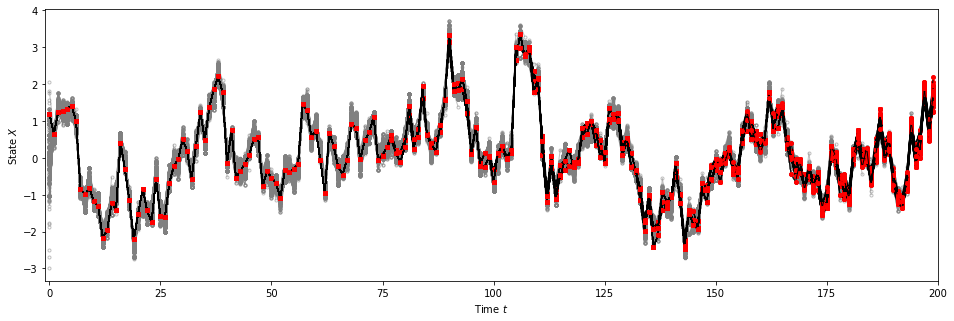

In [131]:
plot_trajectories(x_fapf.T[:, :200], ancs_fapf.T[:, :200], figname='traj_fapf_multinomial')

## (f) FAPF with systematic resampling

In [132]:
N = 100
theta = [0.8, 2.0, 0.5, 0.1]
x_fapf, w_fapf, ancs_fapf, _ = fully_adapted_particle_filter(y, N, theta, resampling_type='systematic')
x_fapf_T = x_fapf.T
ancs_fapf_T = ancs_fapf.T

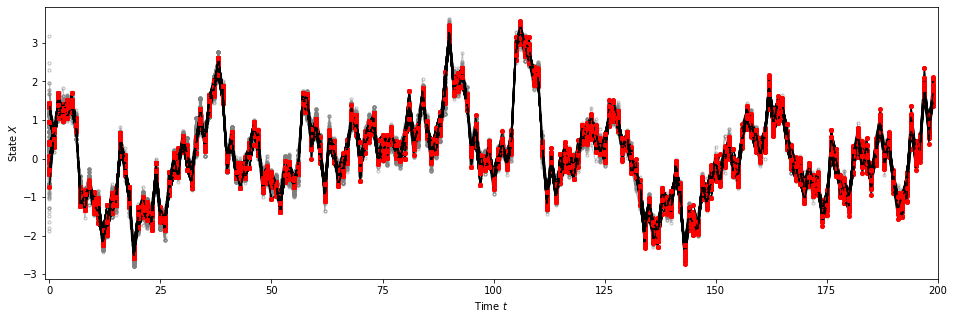

In [133]:
plot_trajectories(x_fapf.T[:, :200], ancs_fapf.T[:, :200], figname='traj_fapf_systematic')

## (g) Plot trajectories with systematic resampling and ESS-trigger

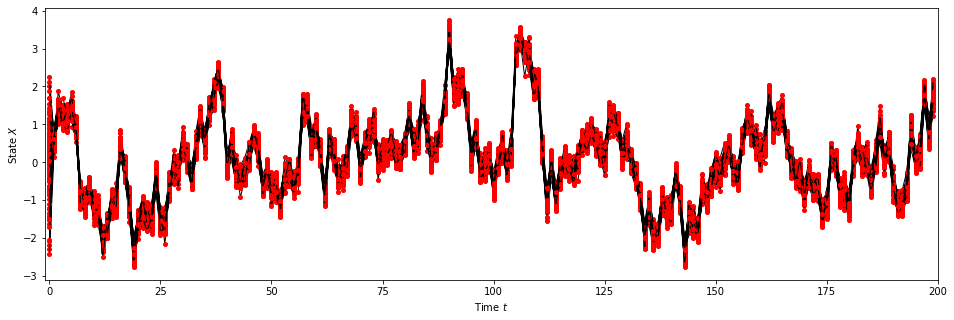

In [134]:
# ESS trigger N/2=50
N = 100
x_fapf, w_fapf, ancs_fapf, N_ess = fully_adapted_particle_filter(y, N, theta, resampling_type='multinomial', ess_trigger=N/2)
x_fapf_T = x_fapf.T
ancs_fapf_T = ancs_fapf.T
plot_trajectories(x_fapf.T[:, :200], ancs_fapf.T[:, :200], figname='traj_fapf_syst_ess')

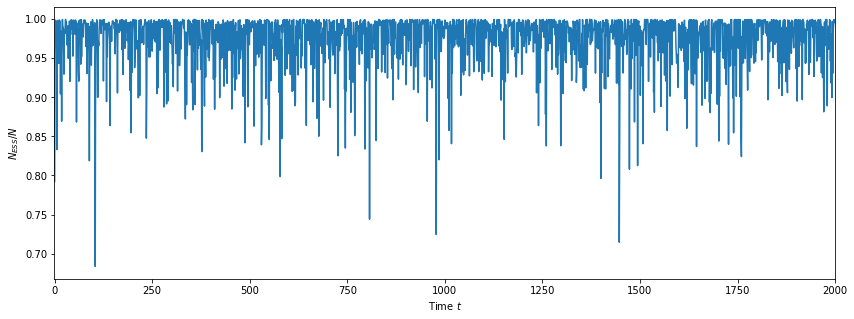

In [121]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(N_ess/N, '-')
ax.set_xlabel("Time $t$"); ax.set_ylabel("$N_{ESS}/N$")
ax.set_xlim(-1, T+1)
plt.show()
fig.savefig('Ness_overN.png')